## 라이브러리 로딩

In [914]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 



import warnings
warnings.filterwarnings(action='ignore')

In [915]:
# matplotlib 한글 깨짐 현상 예방 
import platform      
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows': # 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

## 데이터 불러오기

In [916]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## EDA

In [917]:
# EDA 라이브러리(사용 여부는 자유)
#import pandas_profiling as pp
#train.profile_report()


## 데이터 전처리

### train dataset 전처리

In [918]:
# train
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [919]:
# train 결측치 확인
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [920]:
# colunms 초기화
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철수',
                      '도보 10분거리 내 버스정류장 수': '버스정류장수' }, inplace=True)

In [921]:
# 인근 지하철, 버스정류장 결측치는 주변에 없는 것으로 간주
train['지하철수'] = train['지하철수'].fillna(0) 
train['버스정류장수'] = train['버스정류장수'].fillna(0)

# 지하철 + 버스 합쳐서 대중교통으로 묶기
train['대중교통수'] = train['지하철수'] + train['버스정류장수']
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철수          0
버스정류장수        0
단지내주차면수       0
등록차량수         0
대중교통수         0
dtype: int64

In [922]:
# '공급유형'에서 '임대보증금' 또는 '임대료'가 결측치인 값 찾기
train[train['임대보증금'].isnull() | train['임대료'].isnull()]['공급유형'].unique()

# '공공분양'은 임대료 및 보증금을 받지 않지만,
# '임대상가'는 각 지역의 boxplot을 그려보고 추후 구려

array(['임대상가', '공공분양'], dtype=object)

##### '임대료' 및 '임대료보증금'이 결측치인 행은 대부분 전용면적별세대수가 1인 임대상가 또는 공공분양, 국민임대, 행복주택이 있다.  
국민임대와 행복주택 등 한국의 공공임대주택 프로그램 중 일부로서  
이러한 프로그램은 일반적으로 임대료가 상대적으로 저렴하게 책정되어 있거나 정부 보조금을 받아 임대료가 일부 지원되는 경우가 많다.   
완전히 무료로 제공되는 것은 아니지만, 데이터 전처리 과정에서 0 으로 책정  
1인 임대상가가 국가 또는 지방 정부의 공공임대주택 프로그램에 속할 경우도 마찬가지

In [923]:
# 중간중간 '-'값이 있어, 0으로 대체
train[['임대보증금','임대료']] = train[['임대보증금','임대료']].fillna('0').replace('-','0').astype(int)
train.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철수        0
버스정류장수      0
단지내주차면수     0
등록차량수       0
대중교통수       0
dtype: int64

In [924]:
# '지역', '공급유형' feature 묶기
print('지역:', train['지역'].unique())
print('공급유형:', train['공급유형'].unique())

지역: ['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
공급유형: ['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '공공임대(분납)' '장기전세' '공공분양'
 '행복주택' '공공임대(5년)']


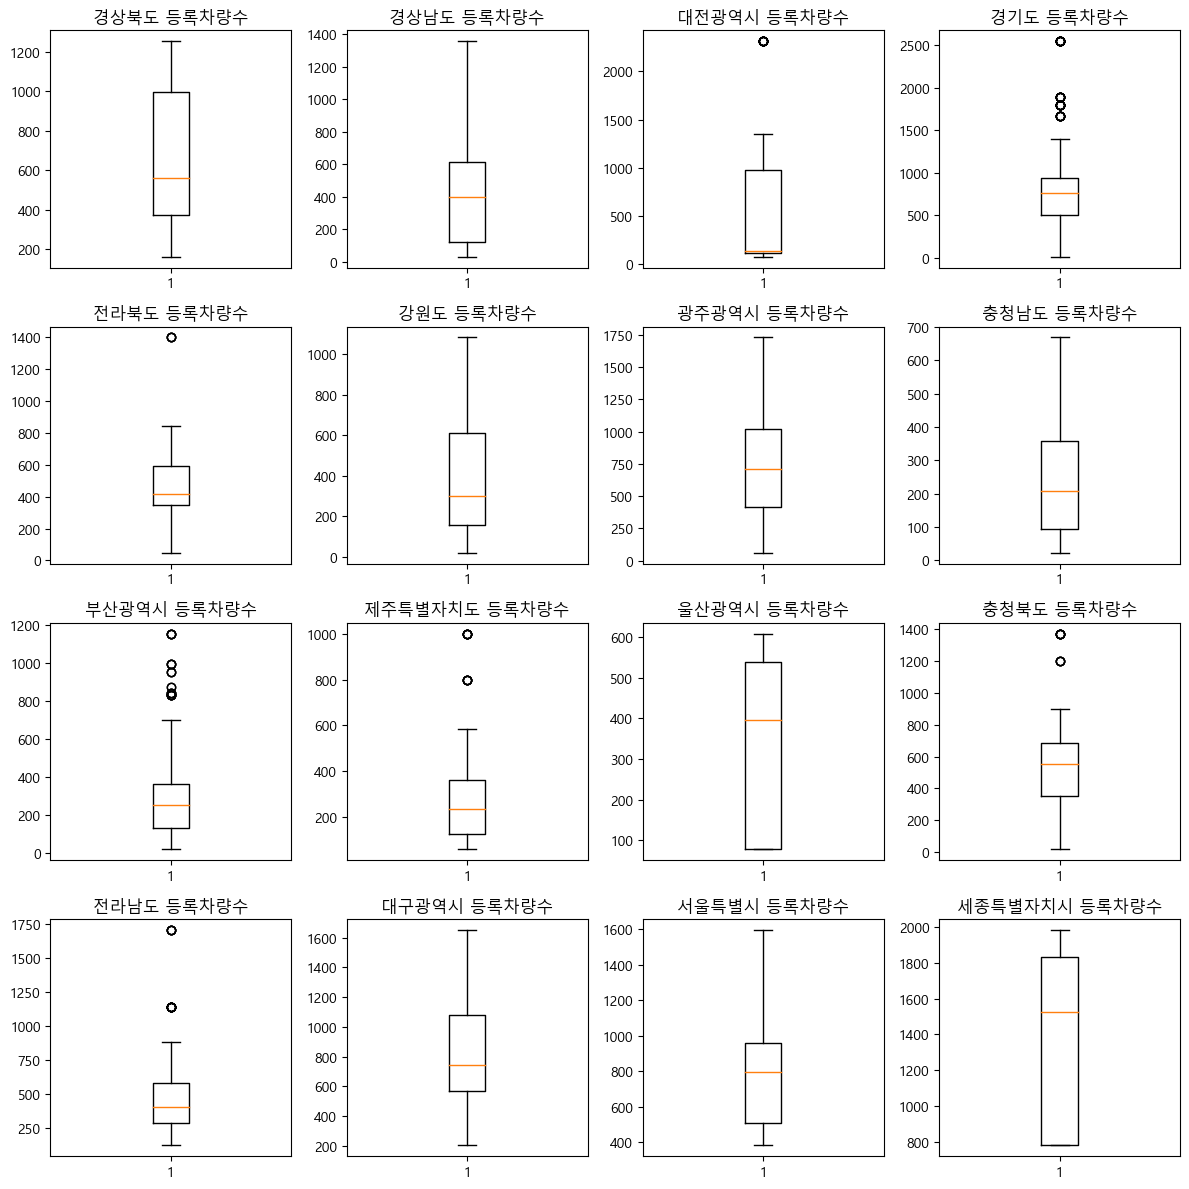

In [925]:
# 위치별 등록차량 수 vs 중간값이 비슷하게 분포된 지역 등록차량 수
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))  # 그림 크기 설정
local = train['지역'].unique()

for i, name in enumerate(local, start=1):  # enumerate에서 start를 1로 설정하여 인덱스를 1부터 시작
    data = pd.to_numeric(train[train['지역']==f'{name}']['등록차량수'], errors='coerce')  # 현재 지역에 해당하는 데이터 가져오기
    plt.subplot(4, 4, i)  # 4x4 그리드에 서브플롯 배치
    plt.boxplot(data)
    plt.title(f'{name} 등록차량수')  # 서브플롯 제목 설정

# 그림 간 간격 조절
plt.tight_layout()

# 그림 표시
plt.show();

In [926]:
# 중간값 비교
for name in local:
    data = pd.to_numeric(train[train['지역']==f'{name}']['등록차량수'], errors='coerce')
    print(f'{name}:', np.median(data))

경상북도: 562.0
경상남도: 398.0
대전광역시: 133.0
경기도: 763.0
전라북도: 415.0
강원도: 302.0
광주광역시: 713.0
충청남도: 209.0
부산광역시: 251.0
제주특별자치도: 235.0
울산광역시: 396.0
충청북도: 553.0
전라남도: 408.0
대구광역시: 744.0
서울특별시: 793.0
세종특별자치시: 1524.0


In [927]:
# 등록차량수 중앙값으로 정렬
area = pd.DataFrame([
    *pd.DataFrame({
        '지역' : train['지역'],
        '등록차량수' : train['등록차량수'],
    })
    .groupby(['지역'])
    .apply(lambda x: {
        '지역' : x.iloc[0, 0],
        'median' : x.등록차량수.median()
        }
    )
]).sort_values('median', ascending=False).reset_index(drop=True)

area

,지역,median
0,세종특별자치시,1524.0
1,서울특별시,793.0
2,경기도,763.0
3,대구광역시,744.0
4,광주광역시,713.0
5,경상북도,562.0
6,충청북도,553.0
7,전라북도,415.0
8,전라남도,408.0
9,경상남도,398.0


In [928]:
# 순위 산정
train.loc[(train['지역'] == '경기도') | (train['지역'] ==  '서울특별시') | (train['지역'] == '세종특별자치시'), '지역순위'] = 1
train.loc[(train['지역'] == '경상북도') | (train['지역'] == '광주광역시') | (train['지역'] =='대구광역시'), '지역순위'] = 2
train.loc[(train['지역'] == '전라남도') | (train['지역'] == '전라북도') | (train['지역'] == '충청북도'), '지역순위'] = 3
train.loc[(train['지역'] == '강원도') | (train['지역'] == '울산광역시') | (train['지역'] == '경상남도'), '지역순위'] = 4
train.loc[(train['지역'] == '대전광역시') | (train['지역'] == '충청남도') | (train['지역'] == '제주특별자치도') | (train['지역'] == '부산광역시'), '지역순위'] = 5


train.dtypes

단지코드         object
총세대수          int64
임대건물구분       object
지역           object
공급유형         object
전용면적        float64
전용면적별세대수      int64
공가수         float64
자격유형         object
임대보증금         int32
임대료           int32
지하철수        float64
버스정류장수      float64
단지내주차면수     float64
등록차량수       float64
대중교통수       float64
지역순위        float64
dtype: object

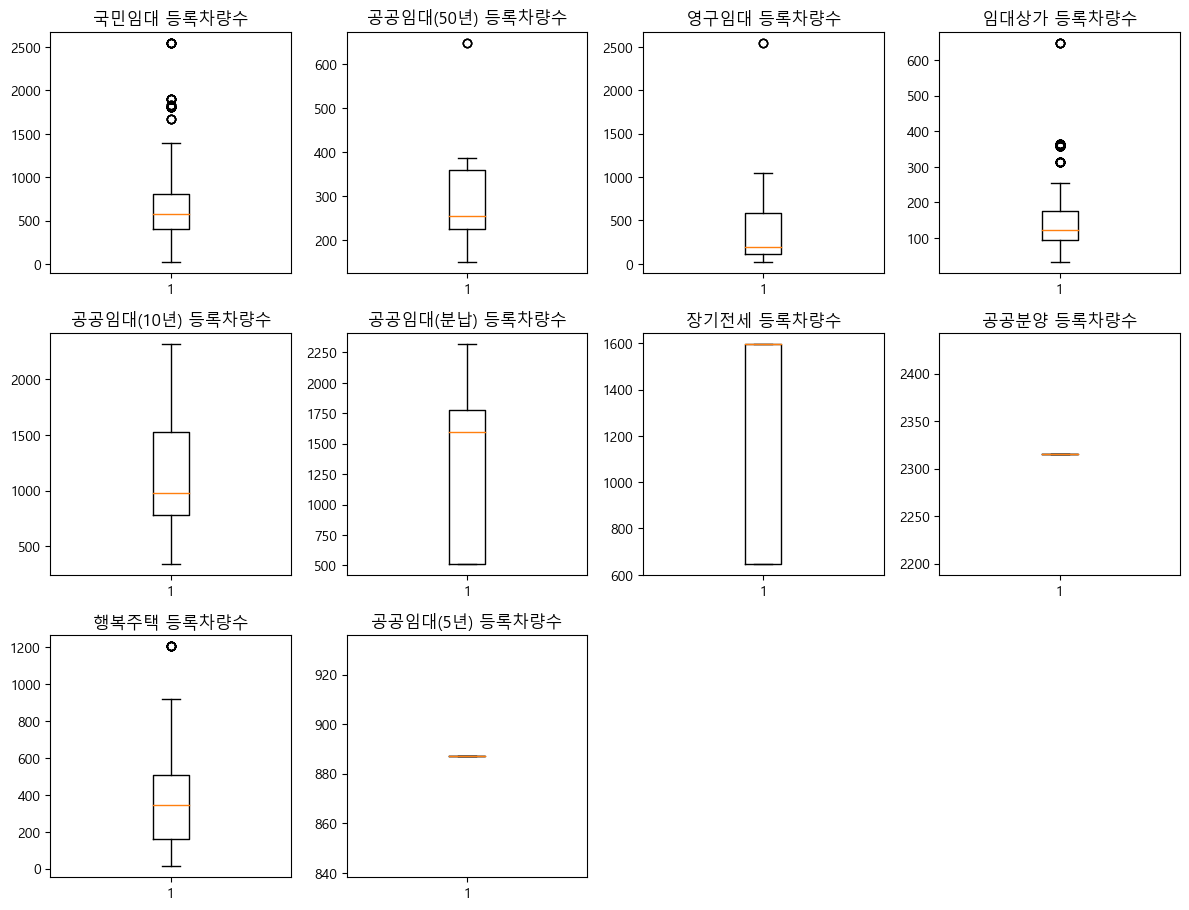

In [929]:
# 공급유형 그룹화
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))  # 그림 크기 설정
apply = train['공급유형'].unique()

for i, name in enumerate(apply, start=1):  # enumerate에서 start를 1로 설정하여 인덱스를 1부터 시작
    data = pd.to_numeric(train[train['공급유형']==f'{name}']['등록차량수'], errors='coerce')  # 현재 지역에 해당하는 데이터 가져오기
    plt.subplot(4, 4, i)  # 4x4 그리드에 서브플롯 배치
    plt.boxplot(data)
    plt.title(f'{name} 등록차량수')  # 서브플롯 제목 설정

# 그림 간 간격 조절
plt.tight_layout()

# 그림 표시
plt.show();

In [930]:
# 공급유형별 데이터 개수 check
apply = train['공급유형'].unique()
for name in apply:
    data = train[train['공급유형']==f'{name}']['등록차량수']
    print(f'{name}', len(data))

국민임대 1758
공공임대(50년) 31
영구임대 152
임대상가 562
공공임대(10년) 205
공공임대(분납) 12
장기전세 9
공공분양 7
행복주택 213
공공임대(5년) 3


In [931]:
# 범주별로 나누기
train.loc[train['공급유형'].isin(['공공임대(50년)']),'공급유형'] = 'A' # '장기공공임대'
train.loc[train['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '공공분양']),'공급유형'] = 'B' # '단기공공임대'
train.loc[train['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형'] = 'C' # '저소득층'
train.loc[train['공급유형'].isin(['국민임대']), '공급유형'] = 'D' # '국민임대'
train.loc[train['공급유형'].isin(['임대상가']), '공급유형'] = 'E' # '임대상가'
train['공급유형'] = train['공급유형'].astype('category')
train.dtypes

단지코드          object
총세대수           int64
임대건물구분        object
지역            object
공급유형        category
전용면적         float64
전용면적별세대수       int64
공가수          float64
자격유형          object
임대보증금          int32
임대료            int32
지하철수         float64
버스정류장수       float64
단지내주차면수      float64
등록차량수        float64
대중교통수        float64
지역순위         float64
dtype: object

In [932]:
# 사용할 열만 가져오기
# 처음엔 모든 행을 사용했으나, 모델링 및 회귀진단을 바탕으로 많은 feature가 삭제되었음
train_final = train[['단지코드', '공급유형', '전용면적', '단지내주차면수', '등록차량수', '지역순위']]
train_final 

,단지코드,공급유형,전용면적,단지내주차면수,등록차량수,지역순위
0,C2483,D,39.72,1425.0,1015.0,2.0
1,C2483,D,39.72,1425.0,1015.0,2.0
2,C2483,D,51.93,1425.0,1015.0,2.0
3,C2483,D,51.93,1425.0,1015.0,2.0
4,C2483,D,51.93,1425.0,1015.0,2.0
...,...,...,...,...,...,...
2947,C2532,D,49.20,166.0,146.0,4.0
2948,C2532,D,51.08,166.0,146.0,4.0
2949,C2532,D,51.73,166.0,146.0,4.0
2950,C2532,D,51.96,166.0,146.0,4.0


In [998]:
# 단지코드별 공급유형별로 그룹화
codes_train = train_final.groupby(['단지코드','공급유형']).agg({
    '지역순위' : 'mean',   # 단지코드별 공급유형별 지역순위 동일
    '단지내주차면수' : 'mean', # 단지코드별 공급유형별 단지내주차면수 동일
    '등록차량수' : 'mean', # 단지코드별 공급유형별등록차량수 동일 
    '전용면적': 'mean', # 단지코드별 평균 전용면적
})
codes_train = codes_train.reset_index().dropna(axis=0)
codes_train = codes_train.reset_index(drop=True)
codes_train

,단지코드,공급유형,지역순위,단지내주차면수,등록차량수,전용면적
0,C1000,D,3.0,438.0,481.0,45.218571
1,C1004,C,5.0,153.0,93.0,39.495000
2,C1004,E,5.0,153.0,93.0,39.094706
3,C1005,D,5.0,950.0,376.0,54.360000
4,C1013,D,2.0,1119.0,1665.0,46.142000
...,...,...,...,...,...,...
477,C2663,D,1.0,700.0,652.0,41.005000
478,C2666,D,5.0,837.0,701.0,43.258333
479,C2670,D,3.0,600.0,435.0,40.918000
480,C2680,D,4.0,564.0,590.0,43.350000


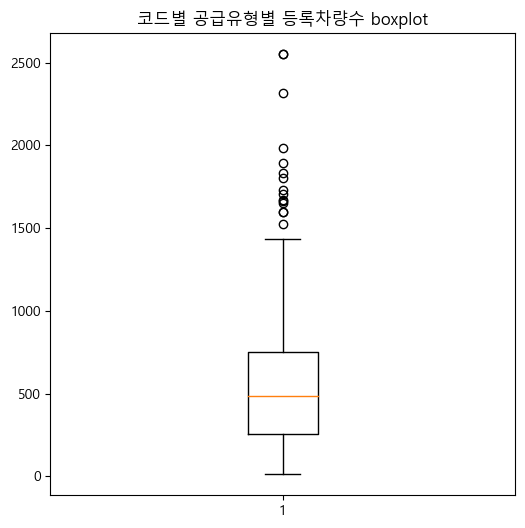

In [999]:
# 등록차량수 이상치 check
# 등록차량수 boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(codes_train['등록차량수'])
plt.title('코드별 공급유형별 등록차량수 boxplot')
plt.show();

In [1000]:
# 등록차량수 이상치 구하기
outliers_regcar = codes_train[codes_train['등록차량수'] > 1500]
outliers_regcar

,단지코드,공급유형,지역순위,단지내주차면수,등록차량수,전용면적
4,C1013,D,2.0,1119.0,1665.0,46.142000
36,C1129,B,1.0,1275.0,1668.0,57.811250
62,C1244,D,1.0,1483.0,1804.0,45.780769
88,C1350,B,5.0,1636.0,2315.0,69.866923
91,C1363,C,1.0,1798.0,2550.0,25.216667
92,C1363,D,1.0,1798.0,2550.0,35.826364
99,C1397,C,1.0,1590.0,1595.0,46.816667
183,C1743,B,2.0,944.0,1653.0,72.310000
198,C1802,B,1.0,1500.0,1983.0,59.523636
237,C1933,B,2.0,1202.0,1730.0,69.566667


In [1002]:
N = codes_train.groupby(['공급유형', '지역순위']).agg({
    '등록차량수': 'mean'
}).round(0)
N

등록차량수
공급유형 지역순위        
A    1.0    382.0
     2.0      NaN
     3.0      NaN
     4.0    376.0
     5.0    269.0
B    1.0   1149.0
     2.0   1159.0
     3.0   1037.0
     4.0    822.0
     5.0   1399.0
C    1.0    740.0
     2.0    434.0
     3.0    342.0
     4.0    211.0
     5.0    214.0
D    1.0    741.0
     2.0    681.0
     3.0    468.0
     4.0    458.0
     5.0    579.0
E    1.0      NaN
     2.0      NaN
     3.0      NaN
     4.0    125.0
     5.0    163.0

In [1003]:
# mean
"""
codes_train.loc[4, '등록차량수'] = 681
codes_train.loc[36, '등록차량수'] = 1149
codes_train.loc[62, '등록차량수'] = 741
codes_train.loc[88, '등록차량수'] = 1399
codes_train.loc[91, '등록차량수'] = 740
codes_train.loc[92, '등록차량수'] = 741
codes_train.loc[99, '등록차량수'] = 740
codes_train.loc[183, '등록차량수'] = 1159
codes_train.loc[198, '등록차량수'] = 1149
codes_train.loc[237, '등록차량수'] = 1159
codes_train.loc[239, '등록차량수'] = 741
codes_train.loc[288, '등록차량수'] = 1149
codes_train.loc[289, '등록차량수'] = 1149
codes_train.loc[458, '등록차량수'] = 741
codes_train.loc[461, '등록차량수'] = 1037

"""


"\ncodes_train.loc[4, '등록차량수'] = 681\ncodes_train.loc[36, '등록차량수'] = 1149\ncodes_train.loc[62, '등록차량수'] = 741\ncodes_train.loc[88, '등록차량수'] = 1399\ncodes_train.loc[91, '등록차량수'] = 740\ncodes_train.loc[92, '등록차량수'] = 741\ncodes_train.loc[99, '등록차량수'] = 740\ncodes_train.loc[183, '등록차량수'] = 1159\ncodes_train.loc[198, '등록차량수'] = 1149\ncodes_train.loc[237, '등록차량수'] = 1159\ncodes_train.loc[239, '등록차량수'] = 741\ncodes_train.loc[288, '등록차량수'] = 1149\ncodes_train.loc[289, '등록차량수'] = 1149\ncodes_train.loc[458, '등록차량수'] = 741\ncodes_train.loc[461, '등록차량수'] = 1037\n\n"

In [1004]:
# median

codes_train.loc[4, '등록차량수'] = 701
codes_train.loc[36, '등록차량수'] = 954
codes_train.loc[62, '등록차량수'] = 657
codes_train.loc[88, '등록차량수'] = 995
codes_train.loc[91, '등록차량수'] = 645
codes_train.loc[92, '등록차량수'] = 657
codes_train.loc[99, '등록차량수'] = 645
codes_train.loc[183, '등록차량수'] = 979
codes_train.loc[198, '등록차량수'] = 954
codes_train.loc[237, '등록차량수'] = 979
codes_train.loc[239, '등록차량수'] = 657
codes_train.loc[288, '등록차량수'] = 954
codes_train.loc[289, '등록차량수'] = 954
codes_train.loc[458, '등록차량수'] = 657
codes_train.loc[461, '등록차량수'] = 1050


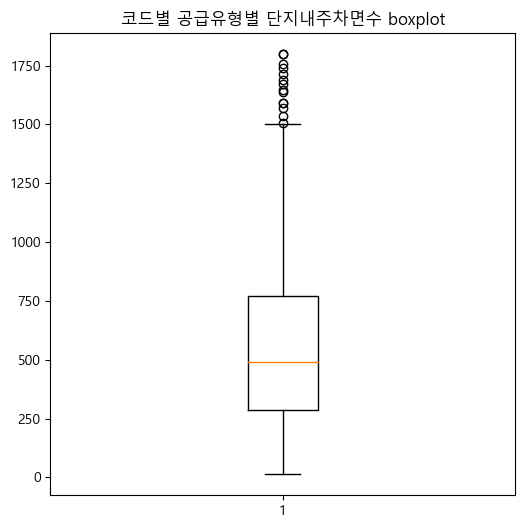

,단지코드,공급유형,지역순위,단지내주차면수,등록차량수,전용면적
7,C1017,D,5.0,1534.0,1246.0,36.836667
49,C1177,D,5.0,1756.0,1044.0,42.277500
78,C1320,D,4.0,1648.0,924.0,38.635000
79,C1326,D,5.0,1670.0,1153.0,32.196000
88,C1350,B,5.0,1636.0,995.0,69.866923
91,C1363,C,1.0,1798.0,645.0,25.216667
92,C1363,D,1.0,1798.0,657.0,35.826364
99,C1397,C,1.0,1590.0,645.0,46.816667
101,C1406,D,5.0,1741.0,1350.0,43.022143
203,C1833,D,5.0,1505.0,1001.0,41.670000


In [1005]:
# 단지내 주차면수 이상치 check
# 단지내주자면수 boxplot
plt.figure(figsize=(6, 6))
boxplot = plt.boxplot(codes_train['단지내주차면수'])
plt.title('코드별 공급유형별 단지내주차면수 boxplot')
plt.show()

upper_whisker = boxplot['whiskers'][1].get_ydata()[1]

outliers = codes_train[(codes_train['단지내주차면수'] > upper_whisker)]
outliers

In [1006]:
N = codes_train.groupby(['공급유형', '지역순위']).agg({
    '단지내주차면수' : 'median'
}).round(0)
N

단지내주차면수
공급유형 지역순위         
A    1.0     362.0
     2.0       NaN
     3.0       NaN
     4.0     226.0
     5.0     375.0
B    1.0     816.0
     2.0     944.0
     3.0     987.0
     4.0     516.0
     5.0    1001.0
C    1.0     879.0
     2.0     650.0
     3.0     350.0
     4.0     154.0
     5.0     238.0
D    1.0     680.0
     2.0     585.0
     3.0     475.0
     4.0     508.0
     5.0     580.0
E    1.0       NaN
     2.0       NaN
     3.0       NaN
     4.0     122.0
     5.0     217.0

In [1007]:

codes_train.loc[7, '단지내주차면수'] = 580
codes_train.loc[49, '단지내주차면수'] = 580
codes_train.loc[78, '단지내주차면수'] = 508
codes_train.loc[79, '단지내주차면수'] = 580
codes_train.loc[88, '단지내주차면수'] = 1001
codes_train.loc[91, '단지내주차면수'] = 879
codes_train.loc[92, '단지내주차면수'] = 680
codes_train.loc[99, '단지내주차면수'] = 879
codes_train.loc[101, '단지내주차면수'] = 580
codes_train.loc[203, '단지내주차면수'] = 580
codes_train.loc[239, '단지내주차면수'] = 680
codes_train.loc[288, '단지내주차면수'] = 816
codes_train.loc[394, '단지내주차면수'] = 879
codes_train.loc[458, '단지내주차면수'] = 680

codes_train.loc[48, '단지내주차면수'] = 475
codes_train.loc[62, '단지내주차면수'] = 680
codes_train.loc[198, '단지내주차면수'] = 816
codes_train.loc[285, '단지내주차면수'] = 680


In [1008]:
# '공급유형' 열 범주형 변수 One-Hot encoding
import pandas as pd

# One-Hot encoding
encoded_train = pd.get_dummies(codes_train, columns=['공급유형'], prefix=['공급유형'])
encoded_train.iloc[:, -5:] = encoded_train.iloc[:, -5:].astype(int)
encoded_train


,단지코드,지역순위,단지내주차면수,등록차량수,전용면적,공급유형_A,공급유형_B,공급유형_C,공급유형_D,공급유형_E
0,C1000,3.0,438.0,481.0,45.218571,0,0,0,1,0
1,C1004,5.0,153.0,93.0,39.495000,0,0,1,0,0
2,C1004,5.0,153.0,93.0,39.094706,0,0,0,0,1
3,C1005,5.0,950.0,376.0,54.360000,0,0,0,1,0
4,C1013,2.0,1119.0,701.0,46.142000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
477,C2663,1.0,700.0,652.0,41.005000,0,0,0,1,0
478,C2666,5.0,837.0,701.0,43.258333,0,0,0,1,0
479,C2670,3.0,600.0,435.0,40.918000,0,0,0,1,0
480,C2680,4.0,564.0,590.0,43.350000,0,0,0,1,0


In [1009]:
# 중간 저장
encoded_train.to_excel('encoded_train.xlsx', index=False)

### test dataset 전처리

In [944]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [945]:
# test 결측치 check
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [946]:
# colunms 초기화
test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철수',
                     '도보 10분거리 내 버스정류장 수': '버스정류장수' }, inplace=True)
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철수,버스정류장수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [947]:
# 인근 지하철, 버스정류장 결측치는 주변에 없는 것으로 간주
test['지하철수'] = test['지하철수'].fillna(0) 
test['버스정류장수'] = test['버스정류장수'].fillna(0)

# 지하철 + 버스 합쳐서 대중교통으로 묶기
test['대중교통수'] = test['지하철수'] + test['버스정류장수']
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna('0').replace('-','0').astype(int)


# 자격유형은 필요한 feature가 아니라서, 결측치 처리 하지않음
test.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        2
임대보증금       0
임대료         0
지하철수        0
버스정류장수      0
단지내주차면수     0
대중교통수       0
dtype: int64

In [948]:
# test dataset도 train의 '지역' feature 따라 그룹화
test.loc[(test['지역'] == '경기도') | (test['지역'] ==  '서울특별시') | (test['지역'] == '세종특별자치시'), '지역순위'] = 1
test.loc[(test['지역'] == '경상북도') | (test['지역'] == '광주광역시') | (test['지역'] =='대구광역시'), '지역순위'] = 2
test.loc[(test['지역'] == '전라남도') | (test['지역'] == '전라북도') | (test['지역'] == '충청북도'), '지역순위'] = 3
test.loc[(test['지역'] == '강원도') | (test['지역'] == '울산광역시') | (test['지역'] == '경상남도'), '지역순위'] = 4
test.loc[(test['지역'] == '대전광역시') | (test['지역'] == '충청남도') | (test['지역'] == '제주특별자치도') | (test['지역'] == '부산광역시'), '지역순위'] = 5

In [949]:
# test dataset도 train의 '공급유형' feature 따라 그룹화
test.loc[test['공급유형'].isin(['공공임대(50년)']),'공급유형'] = 'A' # '장기공공임대'
test.loc[test['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '공공분양']),'공급유형'] = 'B' # '단기공공임대'
test.loc[test['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형'] = 'C' # '저소득층'
test.loc[test['공급유형'].isin(['국민임대']), '공급유형'] = 'D' # '국민임대'
test.loc[test['공급유형'].isin(['임대상가']), '공급유형'] = 'E' # '임대상가'
test['공급유형'] = test['공급유형'].astype('category')

test.dtypes

단지코드          object
총세대수           int64
임대건물구분        object
지역            object
공급유형        category
전용면적         float64
전용면적별세대수       int64
공가수          float64
자격유형          object
임대보증금          int32
임대료            int32
지하철수         float64
버스정류장수       float64
단지내주차면수      float64
대중교통수        float64
지역순위         float64
dtype: object

In [950]:
# 필요한 열만 가져오기
# train과 동일해야함
test_final = test[['단지코드', '공급유형', '전용면적', '단지내주차면수',  '지역순위']]
test_final 

,단지코드,공급유형,전용면적,단지내주차면수,지역순위
0,C1072,D,39.79,683.0,1.0
1,C1072,D,46.81,683.0,1.0
2,C1072,D,46.90,683.0,1.0
3,C1072,D,46.90,683.0,1.0
4,C1072,D,51.46,683.0,1.0
...,...,...,...,...,...
1017,C1267,C,36.77,467.0,4.0
1018,C2189,D,29.19,300.0,3.0
1019,C2189,D,29.19,300.0,3.0
1020,C2189,D,39.45,300.0,3.0


In [951]:
codes_test = test_final.groupby(['단지코드','공급유형']).agg({
    '지역순위' : 'mean',      # 단지코드별 지역순위 동일
    '단지내주차면수' : 'mean', # 단지코드별 단지내주차면수 동일
    '전용면적': 'mean',       # 단지코드별 평균 전용면적
}).reset_index(drop=False)
codes_test = codes_test.dropna(axis=0)
codes_test = codes_test.reset_index(drop=True)
codes_test

,단지코드,공급유형,지역순위,단지내주차면수,전용면적
0,C1003,C,4.0,339.0,32.136250
1,C1006,C,5.0,428.0,30.844286
2,C1006,E,5.0,428.0,71.411500
3,C1016,D,1.0,646.0,48.142500
4,C1019,D,5.0,259.0,44.875000
...,...,...,...,...,...
158,C2676,C,5.0,418.0,28.020000
159,C2676,E,5.0,418.0,55.675581
160,C2688,C,3.0,107.0,24.625000
161,C2688,D,3.0,107.0,33.327500


In [952]:
codes_test['전용면적'] = round(codes_test['전용면적'], -1) # 10 단위

codes_test

,단지코드,공급유형,지역순위,단지내주차면수,전용면적
0,C1003,C,4.0,339.0,30.0
1,C1006,C,5.0,428.0,30.0
2,C1006,E,5.0,428.0,70.0
3,C1016,D,1.0,646.0,50.0
4,C1019,D,5.0,259.0,40.0
...,...,...,...,...,...
158,C2676,C,5.0,418.0,30.0
159,C2676,E,5.0,418.0,60.0
160,C2688,C,3.0,107.0,20.0
161,C2688,D,3.0,107.0,30.0


In [953]:
# train과 같이 범주형 변수 One-Hot encoding
import pandas as pd

# One-Hot encoding
encoded_test = pd.get_dummies(codes_test, columns=['공급유형'], prefix=['공급유형'])
encoded_test.iloc[:, -5:] = encoded_test.iloc[:, -5:].astype(int)
encoded_test


,단지코드,지역순위,단지내주차면수,전용면적,공급유형_A,공급유형_B,공급유형_C,공급유형_D,공급유형_E
0,C1003,4.0,339.0,30.0,0,0,1,0,0
1,C1006,5.0,428.0,30.0,0,0,1,0,0
2,C1006,5.0,428.0,70.0,0,0,0,0,1
3,C1016,1.0,646.0,50.0,0,0,0,1,0
4,C1019,5.0,259.0,40.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
158,C2676,5.0,418.0,30.0,0,0,1,0,0
159,C2676,5.0,418.0,60.0,0,0,0,0,1
160,C2688,3.0,107.0,20.0,0,0,1,0,0
161,C2688,3.0,107.0,30.0,0,0,0,1,0


In [954]:
# 중간 저장
encoded_test.to_excel('encoded_test.xlsx', index=False)

## 모델링 진행

In [955]:
import pandas as pd

train = pd.read_excel('encoded_train.xlsx')
test = pd.read_excel('encoded_test.xlsx')

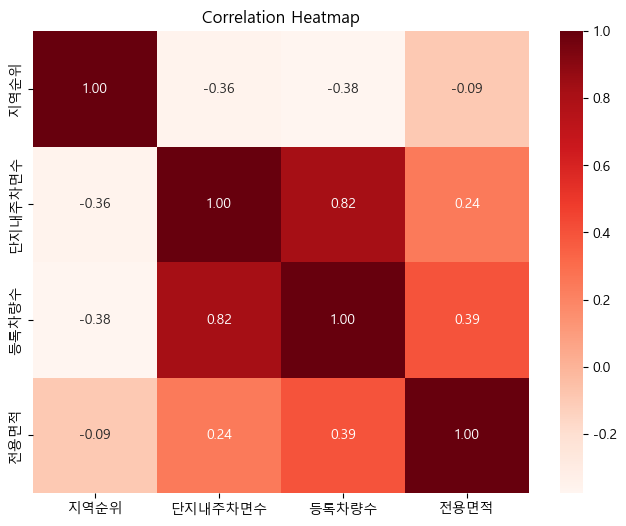

In [956]:
# train 상관계수 파악
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = codes_train.drop(columns=['단지코드', '공급유형']).corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [957]:
# X, y train, test dataset 분리
import statsmodels.api as sm

# train
X_train = train.drop(columns=['등록차량수', '단지코드'])
y_train = train['등록차량수']

# test
X_test = test

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


In [958]:
import numpy as np
import statsmodels.api as sm

# OLS model
model = sm.OLS(y_train, X_train).fit(fit_intercept=False, n_jobs=-1)

# 모델링
y_pred = model.predict(X_train)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  등록차량수   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     183.6
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          1.32e-130
Time:                        13:37:47   Log-Likelihood:                -3157.2
No. Observations:                 482   AIC:                             6330.
Df Residuals:                     474   BIC:                             6364.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.4187     51.932      0.778      0.437     -61.627     142.465
지역순위         -15.4770      5.792     -2.672      0.008     -26.859      -4.095
단지내주차면수        0.7079      0.028     25.518      0.000       0.653       0.762
전용면적           2.9597      1.184      2.500      0.013       0.634       5.286
공급유형_A         2.2290     44.407      0.050      0.960     -85.031      89.489
공급유형_B       151.5741     48.471      3.127      0.002      56.329     246.819
공급유형_C       -28.7945     22.461     -1.282      0.200     -72.929      15.340
공급유형_D        19.8440     16.633      1.193      0.233     -12.840      52.528
공급유형_E      -104.4339     29.222     -3.574      0.000    -161.854     -47.014
==============================================================================
Omnibus:                       63.830   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.069
Skew:                           0.556   Prob(JB):                     2.99e-50
Kurtosis:                       6.181   Cond. No.                     2.23e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.88e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [959]:
from sklearn.metrics import mean_absolute_error

# Assuming y_true contains the actual values and y_pred contains the predicted values
y_true = train['등록차량수']  # Actual values
y_pred = y_pred

mae = mean_absolute_error(y_true, y_pred).round(2)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 117.66


## 회귀 진단

In [1011]:
import pandas as pd
# 삭제가능 회귀진단 테스트한다고 해놨
train = pd.read_excel('encoded_train.xlsx')
train

,단지코드,지역순위,단지내주차면수,등록차량수,전용면적,공급유형_A,공급유형_B,공급유형_C,공급유형_D,공급유형_E
0,C1000,3,438,481,45.218571,0,0,0,1,0
1,C1004,5,153,93,39.495000,0,0,1,0,0
2,C1004,5,153,93,39.094706,0,0,0,0,1
3,C1005,5,950,376,54.360000,0,0,0,1,0
4,C1013,2,1119,701,46.142000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
477,C2663,1,700,652,41.005000,0,0,0,1,0
478,C2666,5,837,701,43.258333,0,0,0,1,0
479,C2670,3,600,435,40.918000,0,0,0,1,0
480,C2680,4,564,590,43.350000,0,0,0,1,0


In [1012]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Linear Regression
lr = LinearRegression()

# 5 fold 교차검증
neg_mse_scores = cross_val_score(lr, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# 출력
print('5 folds of individual Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('Individual RMSE scores of 5 folds: ', np.round(rmse_scores, 2))
print('Average RMSE of 5 folds: {0:.3f}'.format(avg_rmse))


5 folds of individual Negative MSE scores:  [ -9419.27 -10464.29 -10241.19  -8067.14  -8296.05]
Individual RMSE scores of 5 folds:  [ 97.05 102.3  101.2   89.82  91.08]
Average RMSE of 5 folds: 96.289


In [1013]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 독립변수 지정
X = train.drop(columns=['등록차량수', '단지코드'])  # 등록차량수는 종속변수

X = sm.add_constant(X)

# VIF 계산
VIF = pd.DataFrame()
VIF["Variable"] = X.columns
VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIF)
# 범주형 변수 제외, 모두 VIF < 5 이므로 다중공선성 문제없음 


  Variable       VIF
0    const  0.000000
1     지역순위  1.210544
2  단지내주차면수  1.315825
3     전용면적  3.424432
4   공급유형_A       inf
5   공급유형_B       inf
6   공급유형_C       inf
7   공급유형_D       inf
8   공급유형_E       inf


In [1014]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# X, y
X = train.drop(columns=['등록차량수', '단지코드'])
y = train['등록차량수']

# intercept
X = sm.add_constant(X)

# OLS model
model = sm.OLS(y, X)
result = model.fit(fit_intercept=False, n_jobs=-1)

# OLSInfluence object
influence = result.get_influence()

# Cook's Distance 계산
(c, p) = influence.cooks_distance

# threshold(한계점) 산정
# 보통 1/len(x) 또는 n/len(x) 값을 사용한다고 함
threshold = 1/len(X)
print('threshold: ', threshold)

# 영향력이 큰 outlier_indeces 산정
outlier_indices = np.where(c > threshold)[0]

# oulier_indices index 출력
print("Indices of influential observations:")
print(outlier_indices)


threshold:  0.002074688796680498
Indices of influential observations:
[  3   4   6   7  12  13  24  35  36  37  49  61  69  70  74  78  79  87
  99 101 104 107 110 126 133 134 139 140 146 161 163 175 176 177 189 195
 203 207 209 210 212 224 237 264 268 270 275 277 279 285 289 300 301 308
 316 329 342 343 346 354 357 367 370 374 375 384 386 388 390 391 394 400
 403 409 412 419 430 444 446 447 450 459 460 471]


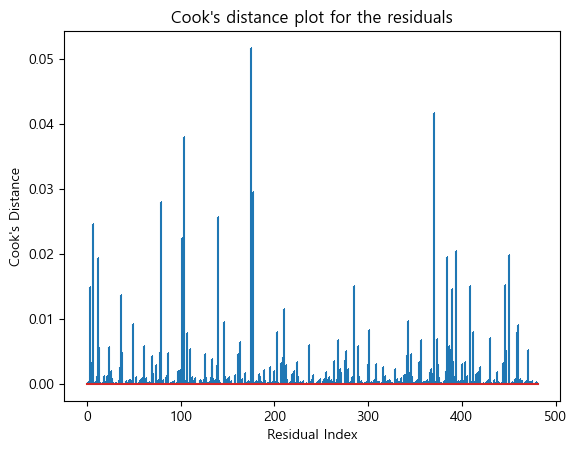

In [1015]:
# OLS 모델 생성 및 학습
model = sm.OLS(y, sm.add_constant(X))
result = model.fit(fit_intercept=False, n_jobs=-1)

# OLSInfluence 객체 생성
influence = result.get_influence()

# Cook's Distance 계산
(c, p) = influence.cooks_distance

# Cook's Distance plot 그리기 
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Cook's distance plot for the residuals")
plt.xlabel("Residual Index")
plt.ylabel("Cook's Distance")
plt.show()

In [1016]:
# 영향력이 큰 influential_data를 훈련데이터셋에서 제외
influential_data = train.iloc[outlier_indices]
drop_data = influential_data.replace(" ", ',')

# drop influential data
train = train.drop(drop_data.index)
train = train.reset_index(drop=True)


# 다시 훈련 데이터 셋 분리 작업
import statsmodels.api as sm

# train
X_train = train.drop(columns=['등록차량수', '단지코드'])
y_train = train['등록차량수']

# test
X_test = test

# intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


398


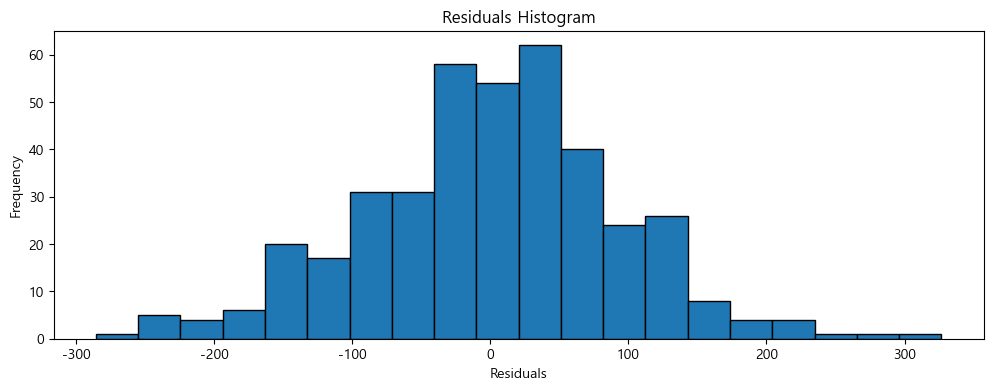

In [1017]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# X, y
X = train.drop(columns=['등록차량수', '단지코드'])
y = train['등록차량수']

# intercept
X = sm.add_constant(X)

# OLS 모델
model = sm.OLS(y, X).fit(fit_intercept=False, n_jobs=-1)
y_pred = model.predict(X)



# influential_data를 제외한 train data에서 예측한 y_pred와 y_train을 기준으로 잔차를 분석

# 모델 피팅 및 잔차 계산
residuals = y_pred - y_train
print(len(y_train))

# 잔차 히스토그램 그리기
plt.figure(figsize=(12, 4))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show();

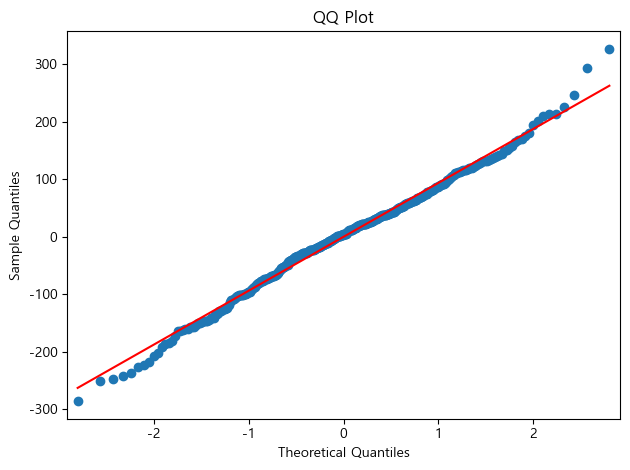

In [1018]:
# QQ 플롯 그리기
sm.qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.tight_layout()

plt.show()

In [1019]:
import numpy as np
import statsmodels.api as sm

X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()

# Predict on the test data
y_pred = model.predict(X)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  등록차량수   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     433.0
Date:                Sun, 24 Sep 2023   Prob (F-statistic):          1.52e-179
Time:                        13:40:48   Log-Likelihood:                -2371.4
No. Observations:                 398   AIC:                             4759.
Df Residuals:                     390   BIC:                             4791.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.9375     35.753     -1.620      0.106    -128.231      12.356
지역순위         -19.0295      3.635     -5.235      0.000     -26.176     -11.883
단지내주차면수        0.7840      0.019     40.351      0.000       0.746       0.822
전용면적           4.9717      0.839      5.925      0.000       3.322       6.621
공급유형_A         6.0624     27.291      0.222      0.824     -47.593      59.717
공급유형_B        14.7289     37.208      0.396      0.692     -58.424      87.882
공급유형_C        -1.7199     14.504     -0.119      0.906     -30.235      26.796
공급유형_D        -7.5909     10.889     -0.697      0.486     -29.000      13.818
공급유형_E       -69.4181     17.967     -3.864      0.000    -104.743     -34.093
==============================================================================
Omnibus:                        3.456   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.743
Skew:                           0.090   Prob(JB):                        0.154
Kurtosis:                       3.439   Cond. No.                     6.13e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.38e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1020]:
""" 
숫자형 변수인 '지역순위', '단지내 주차면수', '전용면적'는 p-value가 모두 0.000인것이 확인된다.
하지만 '공급유형'의 p-value는 0.005이상이다.
'공급유형'은 범주형 변수이고, One-Hot encoding을 처리시켜 모든 값이 0 또는 1이므로
p-value에 대해서 변수간의 독립성을 따지는게 유의미하지 않다.

Durbin-Watson 또한 2에 매우 가깝게 나타난다.

"""

" \n숫자형 변수인 '지역순위', '단지내 주차면수', '전용면적'는 p-value가 모두 0.000인것이 확인된다.\n하지만 '공급유형'의 p-value는 0.005이상이다.\n'공급유형'은 범주형 변수이고, One-Hot encoding을 처리시켜 모든 값이 0 또는 1이므로\np-value에 대해서 변수간의 독립성을 따지는게 유의미하지 않다.\n\nDurbin-Watson 또한 2에 매우 가깝게 나타난다.\n\n"

In [1022]:
from sklearn.metrics import mean_absolute_error

# 회귀 진단 후 MAE 산정
y_true = train['등록차량수']  # Actual values
y_pred = y_pred

mae = mean_absolute_error(y_true, y_pred).round(2)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 72.38


## 제출 파일 생성


In [64]:
submission = pd.read_csv('sample_submission.csv')
submission

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0
...,...,...
145,C2456,0
146,C1266,0
147,C2152,0
148,C1267,0


In [65]:
submission['num'] = y_pred

In [66]:
submission

,code,num
0,C1072,0.318203
1,C1128,0.086861
2,C1456,0.046814
3,C1840,0.692564
4,C1332,0.521462
...,...,...
145,C2456,0.200602
146,C1266,0.640476
147,C2152,0.362118
148,C1267,0.099230


In [67]:
# csv 파일로 저장합니다.
submission.to_csv('baseline.csv', index=False)